<h1 align="left">2. Fair training</h1>

### 실습목표
- Fairness metric 중 하나인 disparate impact을 측정하는 코드 구현.
- Fair dataset과 unfair dataset을 생성.
- 각각의 데이터셋에 logistic regression을 적용한 뒤 성능 및 fairness를 측정.
- Zafar의 fair training 알고리즘 코드 구현 <href>https://arxiv.org/pdf/1507.05259.pdf</href>.
 - Lambda가 주어졌을 때, (Cross entropy loss) + $\lambda$ * (fairness regularization term)을 최소화하는 gradient descent 알고리즘 구현.
- Unfair dataset에 Zafar 알고리즘 기반 logistic regression을 적용한 뒤 성능 및 fairness 측정, $\lambda$ 값에 따른 tradeoff 그래프를 작성.

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

from fair_utils import generate_unfair_data, plot_unfair_data, Normalize, sigmoid, \
initialize_with_zeros, Logistic, forward, draw_boundary, add_line

## 2-A. Synthetic data 생성
- 이번 실습에 사용할 fair/unfair dataset을 생성하자. 앞선 수업에서 보았던 ___criminal reoffending dataset___ 을 만드는데, 여기서 데이터의 feature는 $x_1: $ # of prior criminal records, $x_2$: criminal type, 레이블 $y$: non-reoffend/reoffend within 2 years이다.

In [2]:
(X_train, Y_train, z_train), (X_test, Y_test, z_test) = generate_unfair_data(
    n_samples=5000,
    disc_factor1=1.8,
    disc_factor2=math.pi * 16.0/32.0) # set this factor close to pi/2 to generate fair data

### Visualization of fair data
데이터를 normalize하고 이를 그래프로 그려본 후, 다음의 질문에 답해보자.
- __Q1) 이 데이터셋이 왜 fair한가? Sensitive group에 대해 어떤 bias가 존재하는가?__
- __Q2) 이러한 데이터셋으로부터 학습한 classifier는 어떤 특성을 가지겠는가?__

In [3]:
X_train = Normalize(X_train)
X_test = Normalize(X_test)

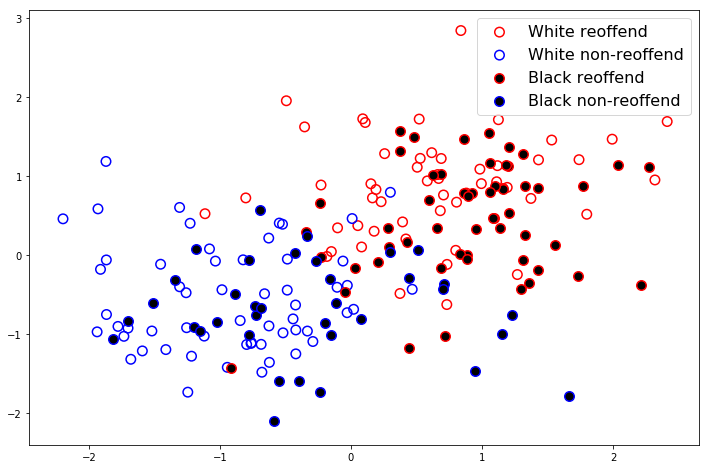

In [4]:
plt.figure(figsize=(12,8))
plot_unfair_data(X_train.T, Y_train, z_train)
plt.show()

### Visualization of unfair data
이번에는 아래 셀의 코드를 실행시켜 또다른 데이터셋을 생성해보자. 마찬가지로 visualize 해본 후 위에서 아래의 질문에 답해보자.
- __Q1) 이 데이터셋이 왜 unfair한가? Sensitive group에 대해 어떤 bias가 존재하는가?__
- __Q2) 이러한 데이터셋으로부터 학습한 classifier는 어떤 특성을 가지겠는가?__

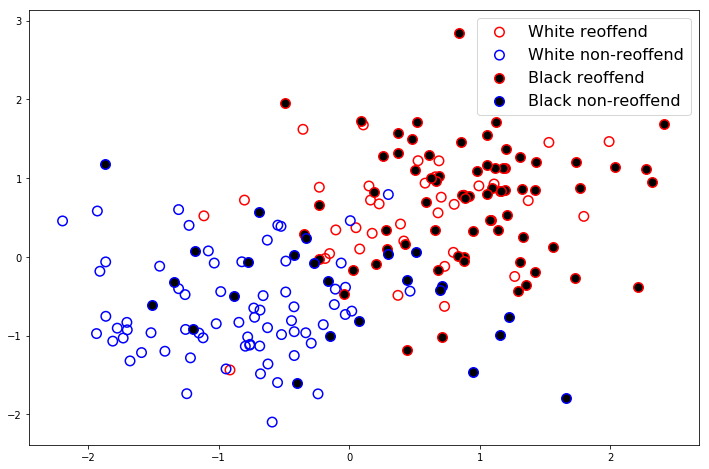

In [5]:
(X_train, Y_train, z_train), (X_test, Y_test, z_test) = generate_unfair_data(
    n_samples=5000,
    disc_factor1=1.8,
    disc_factor2=math.pi * 27.0/32.0) # set this factor far from pi/2 to generate unfair data

X_train = Normalize(X_train)
X_test = Normalize(X_test)

plt.figure(figsize=(12,8))
plot_unfair_data(X_train.T, Y_train, z_train)
plt.show()

### Logistic regression classifier under this dataset
- 지난 Day 1,2때 구현했던 logistic regression 코드를 이용하여 이 데이터셋에서 logistic regression classifier를 학습시키자. 그리고 그렇게 학습한 모델의 decision boundary를 그려보자.

In [6]:
d = Logistic(X_train, Y_train, X_test, Y_test, print_cost=True)

Cost after iteration [2000/2000]: 0.184310
train accuracy: 92.575 %
test accuracy: 93.4 %


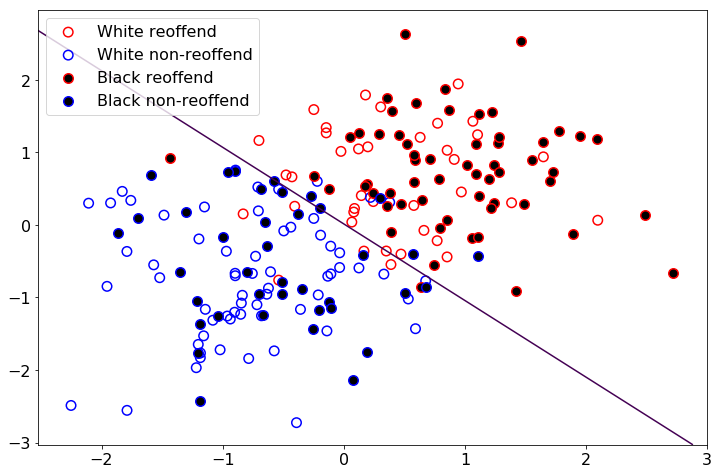

In [7]:
plt.figure(figsize=(12,8))
draw_boundary(d["w"], d["b"], X_test, Y_test, z_test, title='Test data', colormap=False)
axes = plt.gca()
for label in axes.get_xticklabels():
    label.set_fontsize(16)
for label in axes.get_yticklabels():
    label.set_fontsize(16)
plt.show()

## 2-B. Disparate impact (불평등효과 or 간접차별)

$\tilde{y}:= \mathbf{1}\{\hat{y} \geq 0.5\}$,
$\mathrm{DI}:= \mathrm{min}\Big(\dfrac{\mathrm{Pr}(\tilde{y}=1 | z=0)}{\mathrm{Pr}(\tilde{y}=1 | z=1)}, \dfrac{\mathrm{Pr}(\tilde{y}=1 | z=1)}{\mathrm{Pr}(\tilde{y}=1 | z=0)} \Big)$.<br>
위의 $\mathrm{DI}$값이 1에 가까울수록 간접차별이 적은 상황임을 상기하자. 즉, $\mathrm{DI}$값이 1에 가까울수록 더욱 공정한 모델이 학습되었다고 할 수 있다. 여기서 $\mathrm{Pr}(\tilde{y}=1 | z=0)$는 조건부 확률로, $z=0$ 사건이 일어났을 때 $\tilde{y}=1$ 사건이 일어날 확률을 의미한다. 마찬가지로 $\mathrm{Pr}(\tilde{y}=1 | z=1)$는 $z=1$ 사건이 일어났을 때 $\tilde{y}=1$ 사건이 일어날 확률을 의미한다.

#### 실습문제) Disparate impact을 측정하는 함수를 구현하시오.
- 이 함수의 input은 logistic regression classifier의 매개변수인 $w$, $b$와 disparate impact을 측정하고자 하는 test dataset이고, output은 $\mathrm{DI:= min(ratio1, ratio2)}$이다.
- 즉, $\mathrm{ratio1} = \dfrac{\mathrm{Pr}(\tilde{y}=1 | z=0)}{\mathrm{Pr}(\tilde{y}=1 | z=1)}$, $\mathrm{ratio2} = \dfrac{\mathrm{Pr}(\tilde{y}=1 | z=1)}{\mathrm{Pr}(\tilde{y}=1 | z=0)}$를 계산하는 코드를 작성하면 된다.
- Day 1, 2때 실습했던 Logistic regression 관련 코드는 모두 제공.
- $\tilde{y}=1$ 인 사건은 아래 코드에서 _"Ytilde"_ 변수의 값이 1인 경우를 세서 알 수 있음.
- numpy array의 indexing과 np.sum 함수 등을 잘 이용하자.

In [8]:
def measure_disparate_impact(w, b, X, Y, z):
    Yhat, _ = forward(w, b, X, Y)
    Ytilde = np.round(Yhat.reshape(-1))
    
    ### START CODE HERE ###
    z_0_mask = (z == 0.0)
    z_1_mask = (z == 1.0)
    z_0_sum = np.sum(z_0_mask)
    z_1_sum = np.sum(z_1_mask)
    
    Ytilde_1_z_0 = (Ytilde == 1.0)[z_0_mask]
    Ytilde_1_z_1 = (Ytilde == 1.0)[z_1_mask]
    Ytilde_1_z_0_sum = np.sum(Ytilde_1_z_0)
    Ytilde_1_z_1_sum = np.sum(Ytilde_1_z_1)
    
    Prob_Ytilde_1_z_0 = Ytilde_1_z_0_sum / z_0_sum
    Prob_Ytilde_1_z_1 = Ytilde_1_z_1_sum / z_1_sum
    
    ratio1 = Prob_Ytilde_1_z_0 / Prob_Ytilde_1_z_1
    ratio2 = Prob_Ytilde_1_z_1 / Prob_Ytilde_1_z_0
    ### END CODE HERE ###
    
    DI = min(ratio1, ratio2)
    return DI

In [9]:
print("Disparate impact: {:.3f}".format(
    measure_disparate_impact(d["w"], d["b"], X_test, Y_test, z_test)))

Disparate impact: 0.453


## Training fair classifier on this dataset
- 수업 때 배운 DI-regularized classifier를 상기하자. 이때 objective function은 $\mathcal{L}(w) = J(w) + \lambda (1 - \mathrm{DI}) \approx J(w) + \lambda \cdot \Big| \mathrm{Cov}(z, w^T b) \Big| = J(w) + \lambda \cdot \Big|\dfrac{1}{m} \sum_{i=1}^{m}(z^{(i)}-\bar{z})w^T x^{(i)} \Big|$ 이다.

#### 실습문제) Classifier의 forward 함수를 구현하시오.
- 이 함수의 input은 logistic regression classifier의 매개변수인 $w$, $b$와 regularization strength $\lambda$, $\hat{y}$을 계산한 뒤 loss function을 계산하고자 하는 dataset이고, 
- 이 함수의 output은 $\hat{y}, J(w)$, covariance이다.
- 본 실습문제에서는 np.mean, np.sum, np.dot 등을 이용하여 다음의 두 가지 수식을 구현하면 된다.
 - $\bar{z} = \dfrac{1}{m} \sum_{i=1}^{m}z_i$ (변수명 _z_bar_)
 - $\mathrm{Cov}(z, w^T b) = \dfrac{1}{m} \sum_{i=1}^{m}(z^{(i)}-\bar{z})w^T x^{(i)}$ (변수명 _covar_)

In [10]:
def forward_fair(w, b, X, Y, z, lambda_):
    m = X.shape[1]
    Yhat = sigmoid(np.dot(w.T, X) + b)
    cross_entropy = (- 1 / m) * np.sum(Y * np.log(Yhat) + (1 - Y) * (np.log(1 - Yhat)))
    
    ### START CODE HERE ###
    z_bar = np.mean(z)
    covar = (1 / m) * np.sum((z - z_bar) * (np.dot(w.T, X) + b))
    ### END CODE HERE ###
    
    cost = cross_entropy + lambda_ * np.abs(covar)
    return Yhat, cost, covar

#### 실습문제) Classifier의 backward 함수를 구현하시오.
- 이 함수의 input은 logistic regression classifier의 매개변수인 $w, b$와 data $X, Y, z$, 그리고 앞서 계산했던 covariance, regularization strength $lambda$이다.
- 이 함수의 output은 logistic regression classifier의 매개변수인 $w, b$에 대한 gradient $\dfrac{d\mathcal{L}}{dw}, \dfrac{d\mathcal{L}}{db}$이다.
- 본 실습문제에서는 np.dot, np.reshape, np.sum 등을 이용하여 다음의 세 가지 수식을 구현하면 된다.
 - $\mathrm{sgn} = \begin{cases} 1.0 ~~~~~\text{if} ~~\mathrm{covariance} \geq 0 \\ -1.0 ~~\text{if} ~~\mathrm{covariance} < 0 \end{cases}$ (변수명 _sgn_)
 - $\dfrac{d\mathcal{L}}{dw} = \dfrac{1}{m} \cdot X(\hat{Y} - Y)^T$ (변수명 _dw_)
 - $\dfrac{d\mathcal{L}}{db} = \dfrac{1}{m} \sum_{i=1}^{m} (\hat{Y} - Y)$ (변수명 _db_)

<img src="./figures/fairness_figure1.png" width="700" height="500"/>

In [ ]:
def backward_fair(w, b, X, Y, z, Yhat, covar, lambda_):
    m = X.shape[1]
    z_bar = np.mean(z)
    
    ### START CODE HERE ###
    sgn = 1.0 if covar > 0 else -1.0
    dw = (1 / m) * np.dot(X, (Yhat - Y).T) + (lambda_ / m) * sgn * np.dot(X, (z - z_bar).reshape(-1, 1))
    db = (1 / m) * np.sum(Yhat - Y)
    ### END CODE HERE ###
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw, "db": db}
    return grads

위에서 정의한 함수들을 이용하여 logistic regression classifier의 매개변수를 update하는 반복문을 작성한다. 반복문 내에서는 forward, backward를 각각 한 번씩 불러오고, backward의 결과로 얻은 gradient를 이용하여 매개변수를 update한다.

In [12]:
def fit_fair(w, b, X, Y, z, num_iterations, lambda_, learning_rate, print_cost=False):
    costs = []
    
    for i in range(num_iterations):
        # Part1) Cost and gradient calculation (2 lines)
        Yhat, cost, covar = forward_fair(w, b, X, Y, z, lambda_)
        grads = backward_fair(w, b, X, Y, z, Yhat, covar, lambda_)
        
        # Part2) Retrieve derivatives from grads (2 lines)
        dw = grads["dw"]
        db = grads["db"]
        
        # Part3) parameter update (2 lines)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 10 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and (i + 1) % 100 == 0 or (i + 1) == num_iterations:
            print("Cost after iteration [%i/%i]: %f" % (i + 1, num_iterations, cost), end='\r')
    
    if print_cost: sys.stdout.write("\033[K")
    params = {"w": w, "b": b}
    
    return params, costs

학습이 완료된 logistic regression classifier를 이용하여 test 데이터가 들어왔을 때 $\tilde{Y}=\mathbf{1}\{ \hat{Y} \geq 0.5 \}$를 출력하는 predict함수를 구현한다.<br>
$\Big( \mathbf{1}\{ \hat{Y} \geq 0.5 \} = \begin{cases}1 \text{, if } \hat{Y} \geq 0.5 \\ 0 \text{, if } \hat{Y} < 0.5 \end{cases}$, $\hat{Y} = \dfrac{1}{1 + e^{-w^T x + b}}\Big)$

In [13]:
def predict_fair(w, b, X):
    m = X.shape[1]
    assert(w.shape[0] == X.shape[0])
    
    Yhat = sigmoid(np.dot(w.T, X) + b)
    Yhat[Yhat > 0.5] = 1
    Yhat[Yhat <= 0.5] = 0
    Y_prediction = Yhat
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

반복문을 통해 logistic regression classifier의 매개변수를 update해주는 fit_fair 함수와 test 데이터가 들어왔을 때 그 결과값을 출력하는 predict_fair 함수를 이용하여 아래의 함수를 구현한다. 모든 결과값은 d라는 dictionary에 저장하여 출력한다.

In [14]:
def Logistic_fair(X, Y, z, X_test, Y_test, z_test, num_iterations, lambda_, learning_rate, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, costs = fit_fair(w, b, X, Y, z, num_iterations, lambda_, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict_fair(w, b, X_test)
    Y_prediction_train = predict_fair(w, b, X_train)
    
    train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    DI = measure_disparate_impact(w, b, X_test, Y_test, z_test)

    print("train accuracy: {} %".format(train_acc))
    print("test accuracy: {} %".format(test_acc))
    print("disparate impact: {:.3f}".format(DI))
    print()

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "train_acc": train_acc,
         "test_acc": test_acc,
         "DI": DI,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "lambda": lambda_}
    
    return d

위에서 구현한 fair classifier의 성능이 다양한 $\lambda$ 값에 따라 어떻게 변하는지 관찰하고자 한다. 이를 위해 다양한 $\lambda$ 값을 가진 리스트를 lambda_range 변수로 설정하고, 반복문을 통해 이 리스트의 item을 훑으며 $\lambda$가 다른 classifier를 학습한다.

In [15]:
acc_fairness = []
model_history = []
lambda_range = np.concatenate((np.linspace(0.0, 1.2, 7), np.linspace(1.3, 1.8, 16))) # for disc_factor2 = 27/32*pi

num_iterations = 1000
learning_rate = 1.0
for lambda_ in lambda_range:
    ### START CODE HERE ###
    d = Logistic_fair(X_train, Y_train, z_train,
                      X_test, Y_test, z_test,
                      num_iterations, lambda_, learning_rate, print_cost=True)
    ### END CODE HERE ###
    acc_fairness.append((lambda_, d["test_acc"], d["DI"]))
    model_history.append(d)

train accuracy: 92.425 %/10000]: 0.249157
test accuracy: 93.3 %
disparate impact: 0.452

train accuracy: 92.425 %/10000]: 0.357347
test accuracy: 93.1 %
disparate impact: 0.455

train accuracy: 92.4 %00/10000]: 0.443433
test accuracy: 92.6 %
disparate impact: 0.462

train accuracy: 92.125 %/10000]: 0.511462
test accuracy: 92.4 %
disparate impact: 0.462

train accuracy: 91.875 %/10000]: 0.564727
test accuracy: 92.1 %
disparate impact: 0.475

train accuracy: 91.05 %0/10000]: 0.605720
test accuracy: 90.9 %
disparate impact: 0.478

train accuracy: 89.475 %/10000]: 0.636222
test accuracy: 88.8 %
disparate impact: 0.495

train accuracy: 88.45 %0/10000]: 0.647937
test accuracy: 87.3 %
disparate impact: 0.521

train accuracy: 87.625 %/10000]: 0.651347
test accuracy: 86.7 %
disparate impact: 0.538

train accuracy: 86.85 %0/10000]: 0.654516
test accuracy: 85.8 %
disparate impact: 0.550

train accuracy: 86.275 %/10000]: 0.657446
test accuracy: 85.2 %
disparate impact: 0.550

train accuracy: 85.15

### Visualization of results

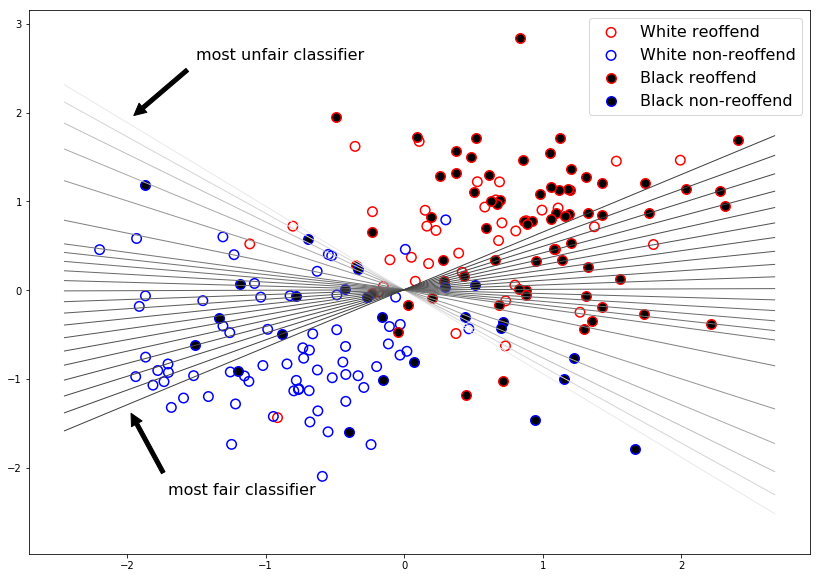

In [17]:
w = model_history[0]["w"]
b = model_history[0]["b"]
plt.figure(figsize=(14,10))
plot_unfair_data(X_train.T, Y_train, z_train)
axes = plt.gca()
xlim, ylim = axes.get_xlim(), axes.get_ylim()

for d in model_history:
    w, b = d["w"], d["b"]
    add_line(xlim, ylim, w, b, level=d["lambda"]/2.4)

axes.annotate("most unfair classifier", xy=(-2, 1.9), xytext=(-1.5, 2.6), fontsize=16,
              arrowprops=dict(facecolor="black", shrink=0.1))
axes.annotate("most fair classifier", xy=(-2, -1.3), xytext=(-1.7, -2.3), fontsize=16,
              arrowprops=dict(facecolor="black", shrink=0.1))
plt.show()

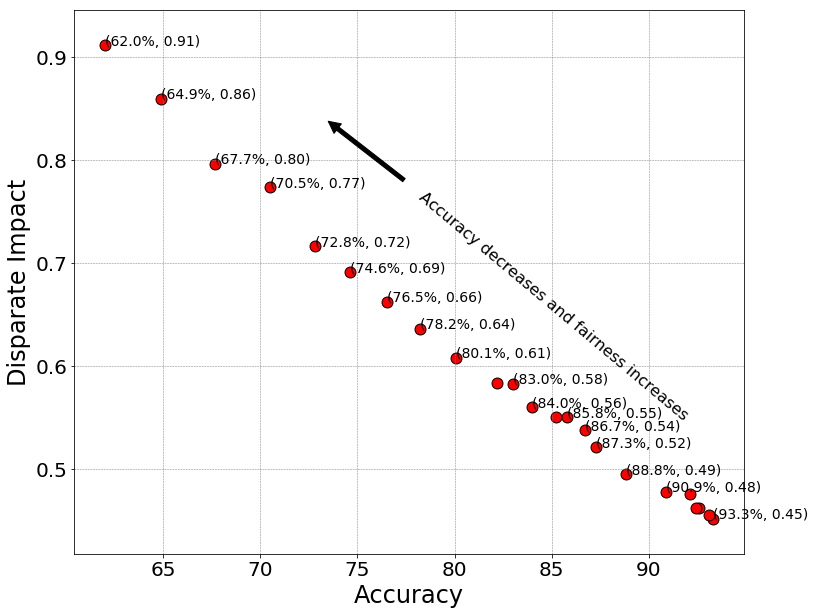

In [23]:
acc_fairness_np = np.array(acc_fairness)
x, y = acc_fairness_np[:, 1], acc_fairness_np[:, 2]
plt.figure(figsize=(12,10))
plt.scatter(x, y, facecolor="red", s=120, edgecolors="k", )
plt.xlabel("Accuracy", fontsize=24)
plt.ylabel("Disparate Impact", fontsize=24)
axes = plt.gca()
for i, xy in enumerate(zip(x,y)):
    if (1 <= i <= 4) or i==10 or i==13:
        continue
    axes.annotate("({:.1f}%, {:.2f})".format(float(xy[0]), float(xy[1])), xy=xy, textcoords="data", fontsize=14)
for label in axes.get_xticklabels():
    label.set_fontsize(20)
for label in axes.get_yticklabels():
    label.set_fontsize(20)

axes.annotate("Accuracy decreases and fairness increases", xy=(73, 0.845), xytext=(78, 0.76),
              fontsize=16, arrowprops=dict(facecolor="black", shrink=0.1), rotation=-40)

plt.grid(color="gray", linestyle="--", linewidth=0.5)
# axes.spines["right"].set_visible(False)
# axes.spines["top"].set_visible(False)
plt.show()

#### Q) 위와 같은 그래프를 accuracy와 fairness 사이의 tradeoff 그래프라고 부른다. 왜 $\lambda$값이 증가함에 따라 점이 좌상단으로 움직이는가?